<a href="https://colab.research.google.com/github/manjuiitm/MLP/blob/main/Transformers_and_Generative_Models_Workshop_Assignment_May_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Welcome to Transformers and Generative Models Workshop**

#### **Instructions**
**1. Use Python 3.x to run this notebook**


**2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.**


**3. Read documentation of each function carefully.**


**4. All the Best!**


**5. Plagiarism is strictly Prohibited, you are suppose to code this on your own. If any is found to plagiarised the code from any student or Web, Strict Disciplinary actions will be taken**



In [ ]:
#imports: do not change them
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import random
from tqdm import tqdm
from torch.utils.data import random_split
from torch.autograd import Variable
import cv2
import torchvision.utils as utils

## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Question 1: MultiHead-Attention
Given a set of query, key, value vectors, calculate the attention value using multihead attention.

choose the closest option to the maximum value of the attention vector


1.   0.5590
2.   0.7851
3.   0.2312
4.   0.9452



In [ ]:
## Please DO NOT change these values.
#This is the config that will be used for implementing the Multi-head attention
config = {
    'QI_DIM': 64,
    'VI_DIM': 64,
    'KI_DIM': 64,
    'QO_DIM': 32,
    'VO_DIM': 32,
    'OP_DIM': 32,
    'NUM_HEADS': 8,
}

In [ ]:
#A class for implementing the Multi-head Attention
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()

        ### YOUR CODE STARTS HERE ###

        #set the op dimension, number of heads based on the value given in config
        self.output_dim = config['OP_DIM']
        self.num_heads = config['NUM_HEADS']
        #set the query dimension as QO_DIM from the config and value dimension as VO_DIM
        self.query_dim = config['QO_DIM']
        self.value_dim = config['VO_DIM']
        #set the respective dimensions
        self.QTrans = nn.Linear(config['QI_DIM'], self.query_dim)
        self.KTrans = nn.Linear(config['KI_DIM'], self.query_dim)
        self.VTrans = nn.Linear(config['VI_DIM'], self.value_dim)

        self.OTrans = nn.Linear(self.value_dim, self.output_dim)

        #set the scaling factor as follows:
        #scale = sqrt(QO_DIM/NUM_HEADS)
        self.scale = math.sqrt(self.query_dim / self.num_heads)
        ### YOUR CODE ENDS HERE ###

    def forward(self, q_inp, k_inp, v_inp, ret_atn=False):

        #making sure that shapes are similar across dim=0
        assert q_inp.shape[0] == k_inp.shape[0]

        #setting batch size
        batch_size = q_inp.shape[0]
        seq_length = q_inp.shape[1]

        ### YOUR CODE STARTS HERE ###
        #pass q_inp, k_inp, v_inp through the linear layers defined in the
        #init function

        Q =  self.QTrans(q_inp)
        K =  self.KTrans(k_inp)
        V =  self.VTrans(v_inp)

        #reshape the Q, K, V tensors to (batch_size, num_heads, -1, self.query_dim/num_heads)
        dim_per_head_q = self.query_dim // self.num_heads
        dim_per_head_v = self.value_dim // self.num_heads

        #hint: you can also do the same by the view() of pytorch
        Q =Q.view(batch_size, seq_length, self.num_heads, dim_per_head_q).permute(0, 2, 1, 3)
        K =K.view(batch_size, seq_length, self.num_heads, dim_per_head_q).permute(0, 2, 1, 3)
        V =V.view(batch_size, seq_length, self.num_heads, dim_per_head_q).permute(0, 2, 1, 3)


        # define energy as matrix product of Q and K divided by self.scale value
        #hint: use torch.matmul() for this and do not forget to reshape K vector as (batch_size, num_heads, self.query_dim/num_heads, -1)
        #this should be done in order to carry out the matrix multiplication
        energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        #define attention as softmax of energy vector across the last dimension
        attention = torch.softmax(energy, dim=-1)

        ### YOUR CODE ENDS HERE ###

        #multiplying the attention with value tensor
        attended = torch.matmul(attention, V).permute(0, 2, 1, 3).contiguous()

        #passing the attended tensor through OTrans linear layer
        out = self.OTrans(attended.view(batch_size, seq_length, -1))

        if ret_atn:
            return out, attention

        else:
            return out

In [ ]:
## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

q = torch.rand(4, 2, 64)
k = torch.rand(4, 2, 64)
v = torch.rand(4, 2, 64)
## Please DONOT remove these lines.

### YOUR CODE STARTS HERE ###

#initialise an instance of MultiHeadAttention class
d =MultiHeadAttention(config)

#pass q, k, v values through the instance
x, y = d(q, k, v, ret_atn=True)

#print the max value of the attention and report your answer
max_attn_val = y.max().item()
print(f"Maximum attention value: {max_attn_val:.4f}")

### YOUR CODE ENDS HERE ###


Maximum attention value: 0.5590


# ViT

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [ ]:

# Define the Patch Embedding class
class PatchEmbedding(nn.Module):
  ### YOUR CODE STARTS HERE ###
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()  # Initialize the parent class
        self.img_size = img_size # Size of the input image (28x28 for MNIST)
        self.patch_size = patch_size # Size of each patch
        self.n_patches = (img_size // patch_size) ** 2  # Number of patches
        # Convolutional layer to create patch embeddings
        self.proj =nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x) # Apply the convolutional projection to create patch embeddings
        x = x.flatten(2)  # Flatten the spatial dimensions
        x =x.transpose(1, 2)  # Transpose to get (batch_size, n_patches, embed_dim)
        return x
  ### YOUR CODE ENDS HERE ###

In [ ]:
# Define the Simple Vision Transformer (ViT) class
class SimpleViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64, num_heads=4, num_layers=2, num_classes=10):
        super().__init__()  # Initialize the parent class
        ### YOUR CODE STARTS HERE ###
        # Create the patch embedding layer
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        ### YOUR CODE ENDS HERE ###
        # Learnable classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Learnable position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))

        # Create the transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )

        # Final classification layer
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        ### YOUR CODE STARTS HERE ###
        x =self.patch_embed(x) # Create patch embeddings
        cls_tokens =self.cls_token.expand(x.size(0), -1, -1)  # Expand cls token to batch size
        x =torch.cat((cls_tokens, x), dim=1)  # Concatenate cls token with patch embeddings
        x = x + self.pos_embed  # Add positional embeddings

        x = self.transformer(x)  # Pass through the transformer encoder
        x = x[:, 0]  # Extract the cls token output
        x = self.fc(x) # Pass through the final classification layer
        ### YOUR CODE ENDS HERE ###
        return x

In [ ]:
### YOUR CODE STARTS HERE ###
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Data preparation
# Define the image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST = 0.1307 mean and std = 0.3081
])

# Load the MNIST train  dataset with transform = transform
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [55000, 5000])
# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)
### YOUR CODE STARTS HERE ###
# Initialize model, loss function, and optimizer
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # Use GPU if available
model =SimpleViT().to(device)  # Create the model and move it to the device
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)   # Define the optimizer with ADAM and learning rate = 0.001

# Training loop
num_epochs = 5  # Number of times to iterate over the entire dataset
train_losses, val_losses = [], []  # Lists to store the losses for plotting

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels =images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad() # Zero out the gradients
        outputs = model(images)  # Forward pass
        loss =criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights
        train_loss+= loss.item() # Accumulate the loss

    train_loss /= len(train_loader)  # Compute average training loss
    train_losses.append(train_loss)
  # Compute average training loss


    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs =model(images) # Get output from the model with images as input
            loss = criterion(outputs, labels) # Compute the loss
            val_loss+= loss.item() # Accumulate the loss

    val_loss /= len(val_loader)  # Compute average validation loss
    val_losses.append(val_loss)

    ### YOUR CODE ENDS HERE ###
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Epoch [1/5], Train Loss: 0.9236, Val Loss: 0.4119
Epoch [2/5], Train Loss: 0.3340, Val Loss: 0.1735
Epoch [3/5], Train Loss: 0.2104, Val Loss: 0.1378
Epoch [4/5], Train Loss: 0.1673, Val Loss: 0.1236
Epoch [5/5], Train Loss: 0.1401, Val Loss: 0.1008


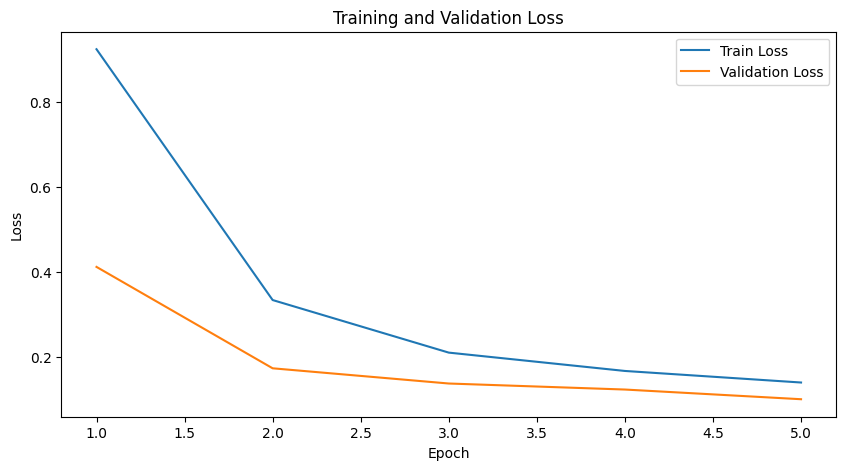

Test Accuracy: 97.10%


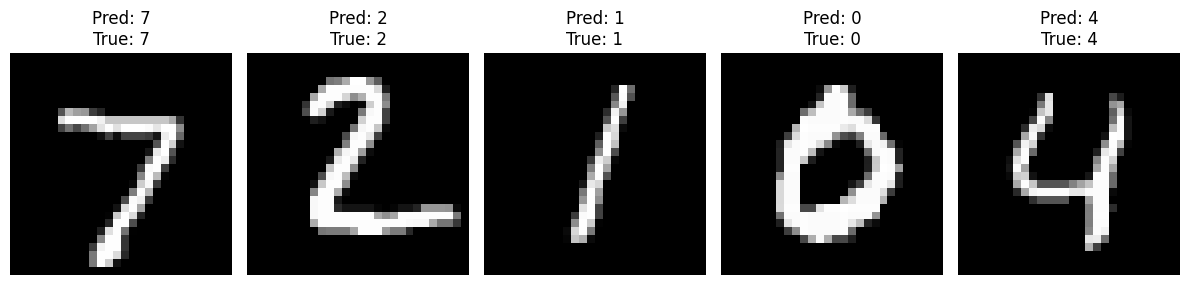

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Function to visualize predictions
def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))  # Get a batch of images
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)  # Get output from the model with images as input
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Display the image
        axes[i].set_title(f'Pred: {predicted[i]}\nTrue: {labels[i]}')  # Show predicted and true labels
        axes[i].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_loader)

### Question 2:
Validation loss saturates after how many epochs?

1.   1
2.   1.5
3.   2
4.   4



### Question 3:
What is the val loss at the end of 5th epoch? (choose the closest value)



1.   0.1077
2.   0.3441
3.   0.783
4.   1.450


### Question 4:
What is the test accuracy? (select closest value)


1.   96.70%
2.   50.39%
3.   85.30%
4.   06.69%


# Cycle-GAN


In this assignment we will implement a Cycle-GAN. Please refer to the following paper: https://arxiv.org/abs/1703.10593 for an understanding of how Cycle-GAN works.


In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import random
import os
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import itertools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# Please do not modify anything in this cell

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(0)

In [ ]:
# Please do not modify anything in this cell

def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [ ]:
# Please do not modify anything in this cell

dtype = torch.float

# set device

device = torch.device("cuda:0")

## Preparing the data

Cycle-GAN is used to translate data from a source domain to a target domain using unpaired samples from both domains. For this implementation we will consider the problem of translating from the usual MNIST images(bright digits with dark background) to their negatives(dark digits in bright background). Although this is a simple translation that can be achieved by pixed value inversion, it will highlight the working principle of Cycle-GAN. We will prepare the target domain data by manually applying the transformation to the regular MNIST data. Note that the generated data does not have a direct mapping between the images in the source domain and their counter parts in the target domain.

download MNIST if not exist


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9ed845ede0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d9ed845ede0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
    ^ ^^ ^ ^ ^ ^^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^^assert self._parent_pid == os.getpid(), 'can only test a child process'
 
  File "/usr/lib/pytho

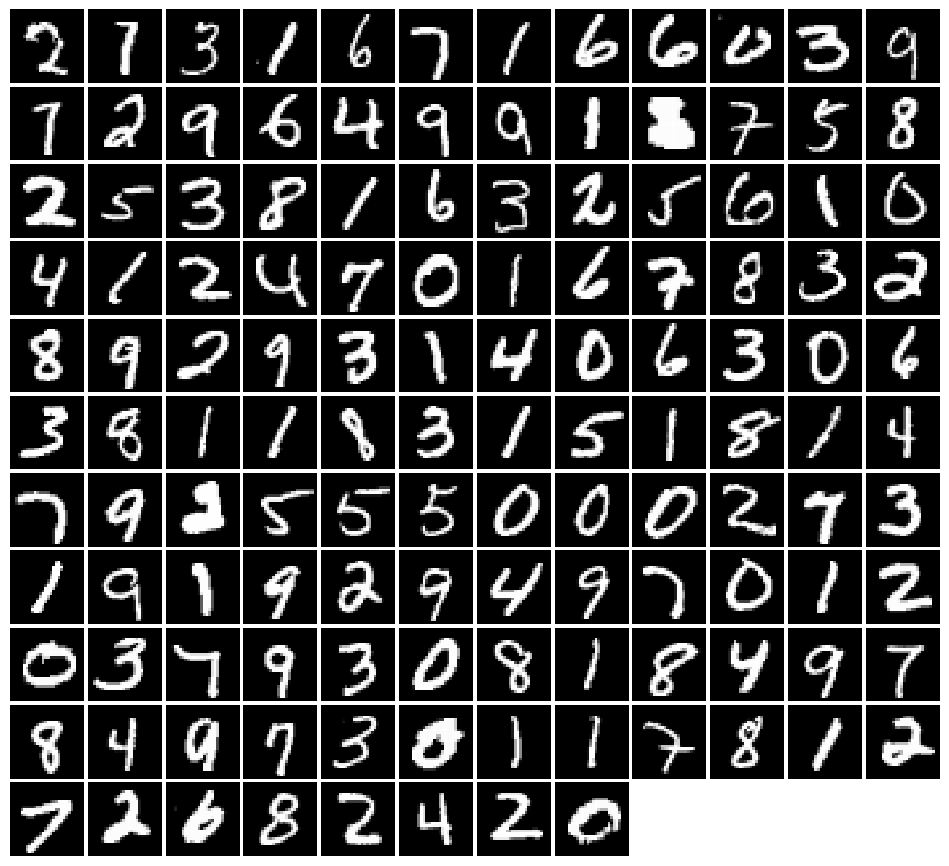

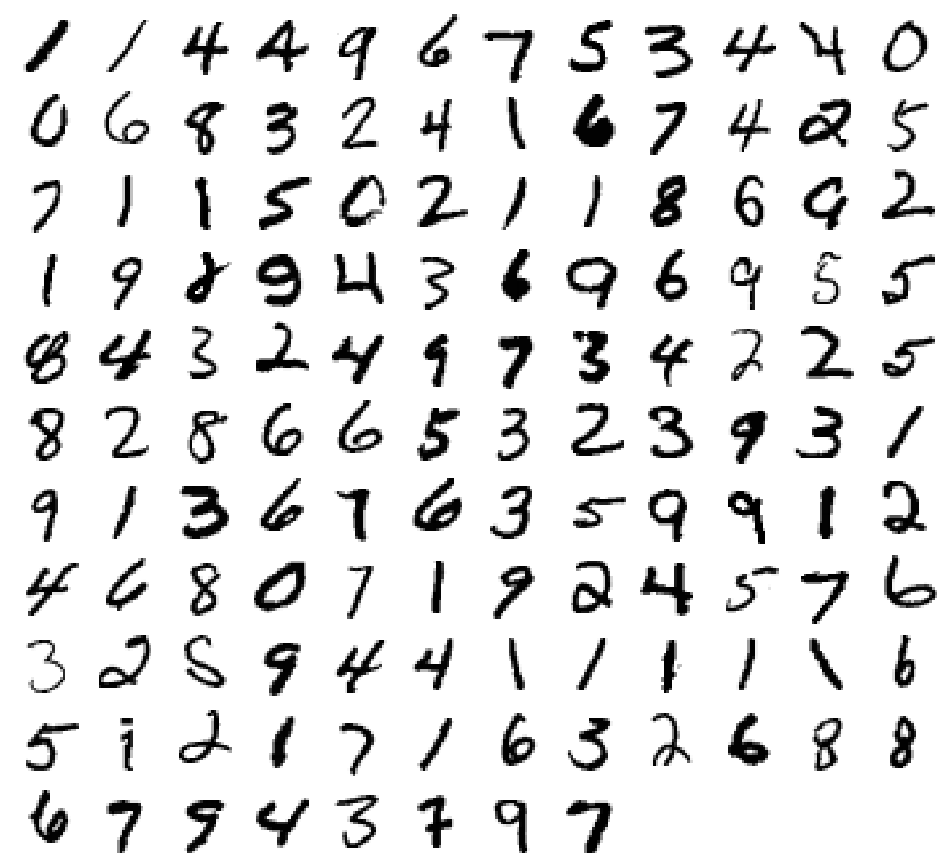

In [ ]:
# Please do not modify anything in this cell

# let us load the input images from the dataset and visualize some images!

batch_size = 128

print('download MNIST if not exist')

transform_A = T.Compose([
        T.ToTensor(), # convert the image to a pytorch tensor
        ])

transform_B = T.Compose([
        T.ToTensor(), # convert the image to a pytorch tensor
        lambda x: T.functional.invert(x) # convert images to their negatives
        ])


# source domain data denoted by domain A
mnist_A_train = dset.MNIST('./data', train=True, download=True,
                       transform=transform_A)

loader_A_train = DataLoader(mnist_A_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


# target domain data denoted by doamin B
mnist_B_train = dset.MNIST('./data', train=True, download=True,
                       transform=transform_B)

loader_B_train = DataLoader(mnist_B_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs_A = next(iter(loader_A_train))[0].view(batch_size, 784)
imgs_B = next(iter(loader_B_train))[0].view(batch_size, 784)

show_images(imgs_A)
show_images(imgs_B)


## Generator and Discriminator

Our Cycle-GAN implementation will contain 2 instances of generators and 1 instance of a discriminator with the following architecture.

### Discriminator

The architecture is:
 * Flatten (Hint: nn.Flatten())
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1 (no activation at output)
  
The output of the discriminator is of shape `[batch_size, 1]`, and contains real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

### Generator

The architecture is:
 * Fully connected layer from 784 to 128
 * `ReLU`
 * Fully connected layer from 128 to 784
 * `TanH` (to clip the image to be in the range of [-1,1])

We will be creating two instances of this generator to go from domain A to B and from B to A respectively. The output of the generators are of shape `[batch_size, 784]`.

In [ ]:
def discriminator():

  #### YOUR CODE STARTS HERE ####

  # Implement a PyTorch nn.Sequential model for the discriminator architecture given above

  model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(0.01),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.01),
        nn.Linear(256, 1)
    )

  #### YOUR CODE ENDS HERE ####

  return model


def generator():

  #### YOUR CODE STARTS HERE ####

  # Implement a PyTorch nn.Sequential model for the generator architecture given above

  model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 784),
        nn.Tanh()
    )

  #### YOUR CODE ENDS HERE ####

  return model

## Loss functions

Cycle-GAN involves the generator, discriminator and the cyclic loss. Please refer to the lecture for detailed explanations.

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
The discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
The cyclic loss is:
$$ \ell_C = -\mathbb{E}_{x \sim p_\text{data}}\left||G_{YX}(G_{XY}(x)- x\right||$$
We will be *minimizing* these losses. We have already implemented the functions to compute generator and discriminator losses. Please go trhough them carefully. You need to write the function for cyclic loss.

In [ ]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.

  Inputs:
  - logits_real: PyTorch Tensor of shape (batch_size, 1) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (batch_size, 1) giving scores for the fake data.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None

  # For the discriminator (D), the true target (y = 1) corresponds to "real" images.
  # Thus, for the scores of real images, the target is always 1 (a vector).
  real_labels = torch.ones_like(logits_real, device=device)
  # Compute the BCE for the scores of the real images.
  # Note that the BCE itself uses the Expectation formula (in addition, an average is
  # taken throughout the losses, not a sum [as requested in this assignment]).
  real_loss = F.binary_cross_entropy_with_logits(logits_real, real_labels)

  # For D, the false target (y = 0) corresponds to "fake" images.
  # Thus, for the scores of fake images, the target is always 0 (a vector).
  fake_labels = torch.zeros_like(logits_fake, device=device)
  # As for the real scores, compute the BCE loss for the fake images.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # Sum "real" and "fake" losses.
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = real_loss + fake_loss

  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (batch_size, 1) giving scores for the fake data.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the generator.
  """
  loss = None

  # For the generator (G), the true target (y = 1) corresponds to "fake" images.
  # Thus, for the scores of fake images, the target is always 1 (a vector).
  fake_labels = torch.ones_like(logits_fake, device=device)
  # Compute the BCE for the scores of the fake images.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # The generator loss is "fake_loss".
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = fake_loss

  return loss

def cycle_loss(original_input, recovered_input):

  """
  Computes the cyclic loss described above.

  Inputs:
  - original_input: PyTorch Tensor of shape (batch_size, 784) represented a batch of input images.
  - recovered_input: PyTorch PyTorch Tensor of shape (batch_size, 784) represented a batch of reconstructed images.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the cyclic loss.
  """
  #### YOUR CODE STARTS HERE ####

  # Implement the cyclic loss as the mean pixel-wise absolute value of difference
  # between the original input and recovered input
  # Hint : F.l1_loss
  loss = F.l1_loss(recovered_input, original_input)

  #### YOUR CODE ENDS HERE ####

  return loss


In [ ]:
# Please do not modify anything in this cell

# this function will be used to alternatively iterate through the batches in both domains
def alternate(*iters):
    for row in zip(*iters):
       for i in row:
           yield i

In [ ]:
def run_cycle_gan(D, G_A2B, G_B2A, D_solver, G_solver, C_solver, discriminator_loss, generator_loss, cycle_loss, show_every=250,
              batch_size=128, num_epochs=10):
  """
  Train a Cycle-GAN!

  Inputs:
  - D, : PyTorch model for the discriminator
  - G_A2B, : PyTorch model for the generator that maps from domain A to B
  - G_B2A, : PyTorch model for the generator that maps from domain B to A
  - D_solver, G_solver, C_solver: torch.optim Optimizers to use for training the
    discriminator, generator(from A to B) and both generators(to cycle from A to A and from B to B)
    respectively.
  - discriminator_loss, generator_loss, cycle_loss : Functions to use for computing the generator loss,
    discriminator loss and cycle loss respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in alternate(loader_A_train, loader_B_train):
      """
      Storing a batch each from domain A and B as real_data_A and
      real_data_B respectively and also normalizing for pixel values to lie in range [-1,1]
      """
      if len(x) != batch_size:
        continue
      if iter_count%2 == 0:
        real_data_A = x.view(-1, 784).to(device)
        real_data_A = 2*(real_data_A - 0.5)
        iter_count += 1
        # go to next batch directly to get domain B data
        continue

      real_data_B = x.view(-1, 784).to(device)
      real_data_B = 2*(real_data_B - 0.5)

      """
      With one batch each loaded from both domains, we now train the network to
      minimize all three losses for these two batches.
      """

      """
      Optimizing discriminator loss
      """

      #### YOUR CODE STARTS HERE ####

      D_solver.zero_grad()

      # compute the classification logits for the real data in B using the discriminator
      logits_real_B = D(real_data_B)

      # generate fake data in domain B from real data in domain A using the Generator
      # from A to B

      fake_data_B = G_A2B(real_data_A)

      # compute the classification logits for the fake data in B using the discriminator
      dis_logits_fake_B = D(fake_data_B.detach())

      # compute the discriminator error using the discriminator_loss function defined above
      # while passing the appropiate params
      d_total_error = discriminator_loss(logits_real_B, dis_logits_fake_B)
      d_total_error.backward()
      D_solver.step()

      """
      Optimizing cylic loss (from A->B->A as well as B->A>B)
      """

      C_solver.zero_grad()

      # generate the recovered data in domain A from the fake data generated in domain B
      # using the generator from B to A
      recovered_A = G_B2A(fake_data_B)

      # compute the cyclic error between the real data from A and the recovered data from A
      # using the cycle_loss function defined above
      c_loss_A = cycle_loss(real_data_A, recovered_A)





      # generate fake data in domain A from real data in domain B using the generator
      # from B to A

      fake_data_A = G_B2A(real_data_B)

      # generate the recovered data in domain B from the fake data generated in domain A
      # using the generator from B to A

      recovered_B = G_A2B(fake_data_A)

      # compute the cyclic error between the real data from B and the recovered data from B
      # using the cycle_loss function defined above
      c_loss_B = cycle_loss(real_data_B, recovered_B)

      c_error = c_loss_A + c_loss_B

      """
      Optimizing generator loss for the generator from A to B to fool the discriminator
      """


      # again generate fake data in domain B from real data in domain A using the
      # generator from A to B
      fake_data_B = G_A2B(real_data_A)

      # compute the classification logits for the fake data in B using the discriminator
      gen_logits_fake_B = D(fake_data_B)

      # compute the generator error using the generator_loss function defined above
      # while passing the appropiate params
      g_error = generator_loss(gen_logits_fake_B)

      g_error.backward()
      G_solver.step()


      #### YOUR CODE ENDS HERE ####

      if (((iter_count-1)/2) % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}, C:{:.4}'.format((iter_count-1)/2,d_total_error.item(),g_error.item(), c_error.item()))

        print('\n Source')
        imgs_numpy = real_data_A.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()

        print('Target')
        imgs_numpy = fake_data_B.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()

        print()
      iter_count += 1


## Executing the Cycle-GAN

Now run the cell below to train the Cycle-GAN!

After every 250 iterations you should see a grid of images from domain A (regular MNIST) and a grid of the generated corresponding images in domain B (negative MNIST). Initially many digits in the target grid will differ from the corresponding images in the source grid but will be digits of similar shapes. Finally there should be a correct or near correct translation from the source domain to the target domain.

Iter: 0.0, D: 1.394, G:0.7266, C:1.897

 Source


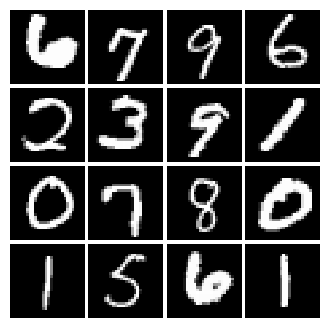

Target


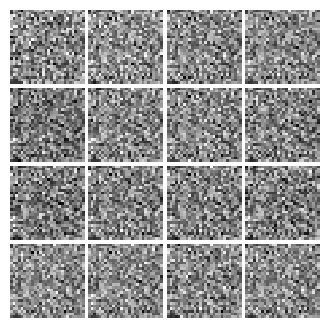


Iter: 250.0, D: 0.1777, G:2.058, C:1.834

 Source


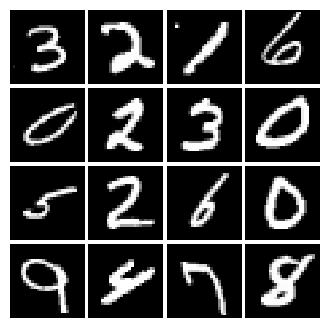

Target


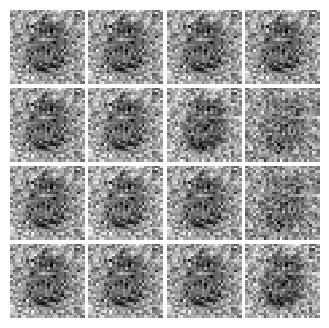


Iter: 500.0, D: 2.271, G:0.7178, C:1.835

 Source


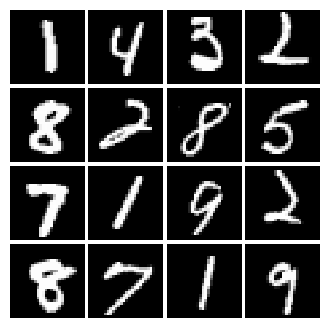

Target


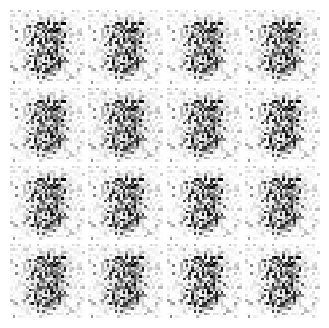


Iter: 750.0, D: 1.422, G:0.7497, C:1.83

 Source


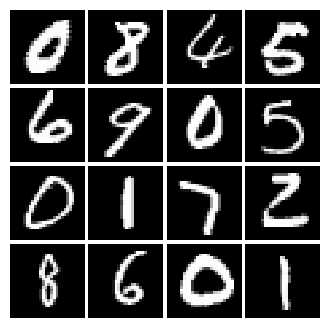

Target


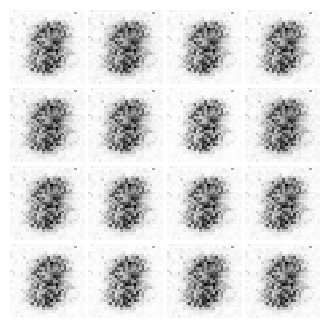


Iter: 1000.0, D: 1.578, G:0.6792, C:1.831

 Source


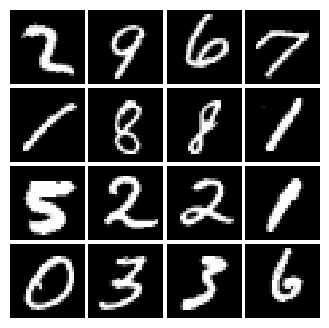

Target


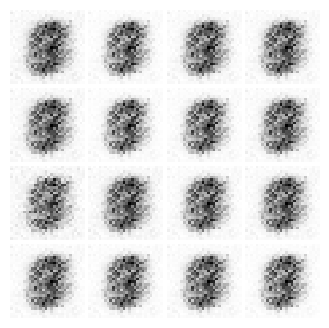


Iter: 1250.0, D: 0.8573, G:1.309, C:1.828

 Source


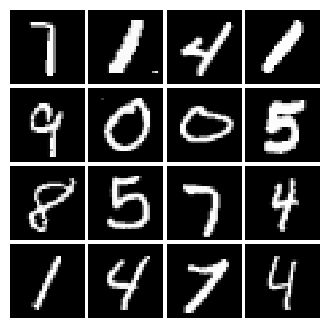

Target


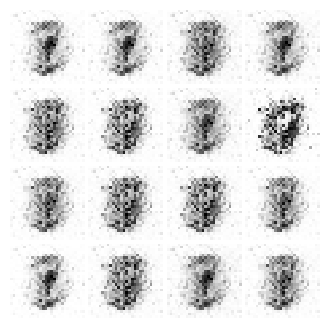


Iter: 1500.0, D: 0.5858, G:1.967, C:1.824

 Source


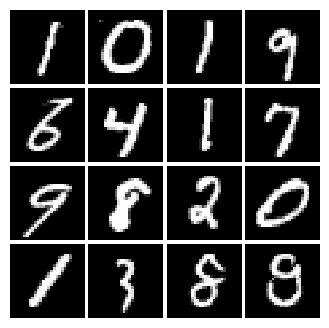

Target


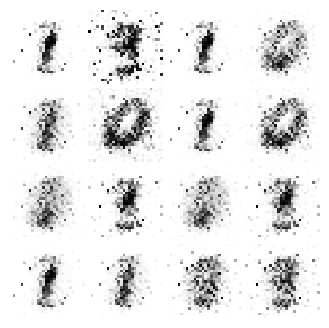


Iter: 1750.0, D: 0.5817, G:1.456, C:1.825

 Source


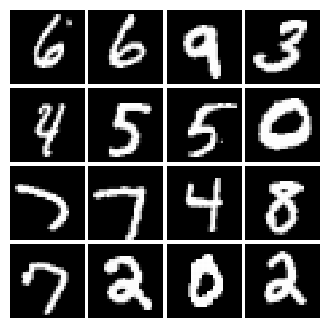

Target


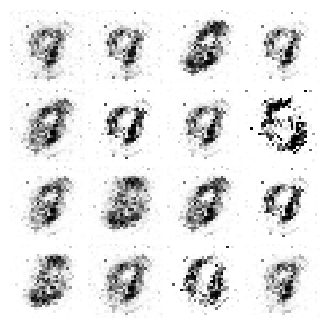


Iter: 2000.0, D: 0.9019, G:9.793, C:1.812

 Source


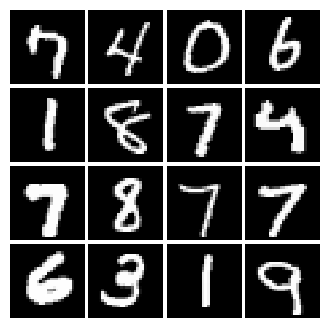

Target


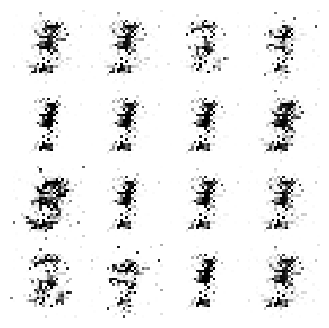


Iter: 2250.0, D: 0.188, G:12.22, C:1.798

 Source


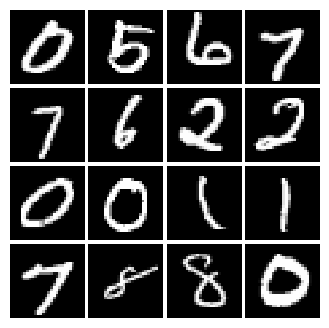

Target


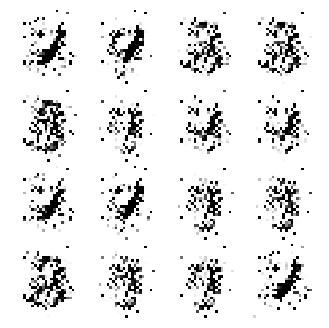


Iter: 2500.0, D: 0.01802, G:8.593, C:1.786

 Source


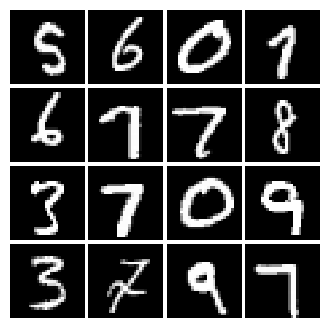

Target


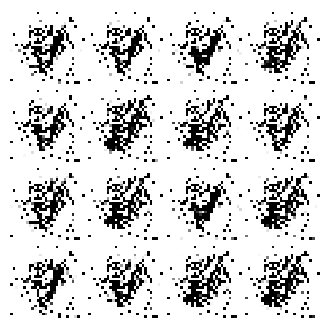


Iter: 2750.0, D: 0.005949, G:5.911, C:1.797

 Source


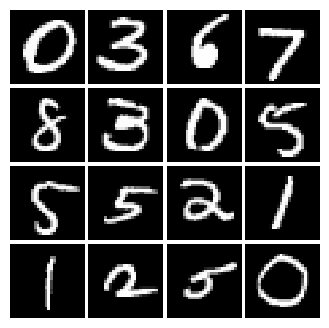

Target


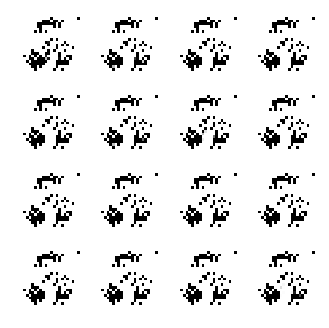


Iter: 3000.0, D: 0.005666, G:5.931, C:1.782

 Source


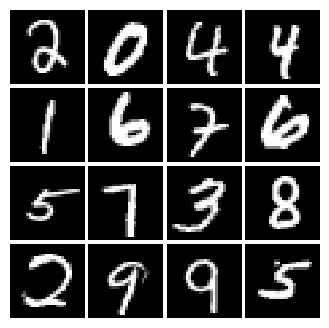

Target


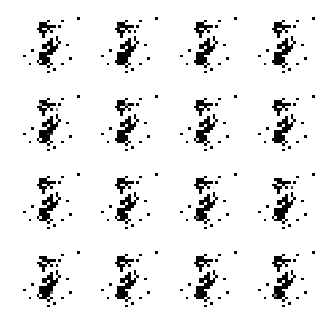


Iter: 3250.0, D: 0.0006529, G:7.805, C:1.78

 Source


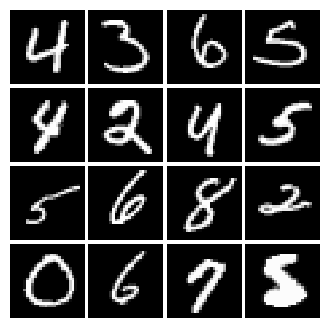

Target


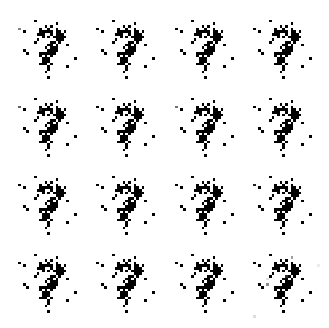


Iter: 3500.0, D: 0.0003369, G:8.798, C:1.769

 Source


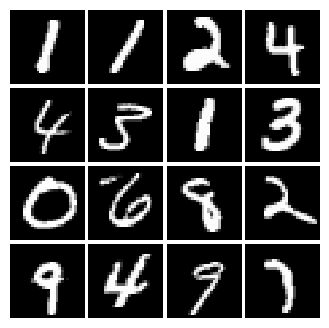

Target


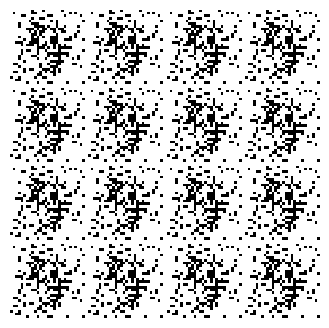


Iter: 3750.0, D: 5.103e-05, G:10.05, C:1.774

 Source


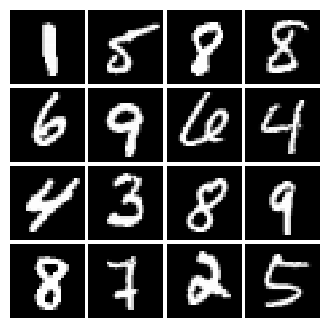

Target


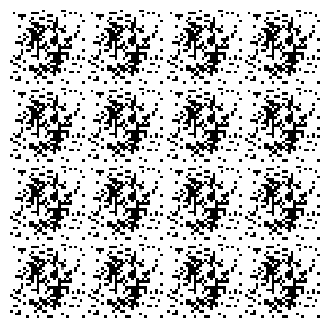


Iter: 4000.0, D: 2.87e-05, G:10.54, C:1.774

 Source


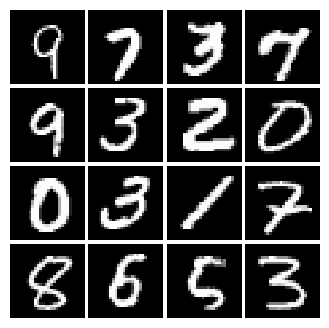

Target


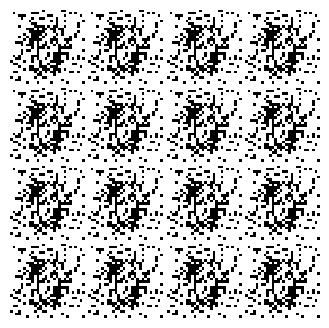


Iter: 4250.0, D: 2.441e-05, G:10.77, C:1.777

 Source


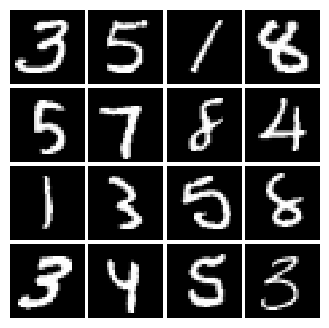

Target


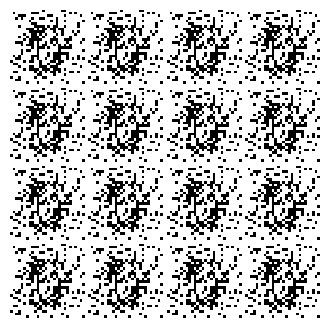


Iter: 4500.0, D: 8.498e-06, G:11.82, C:1.771

 Source


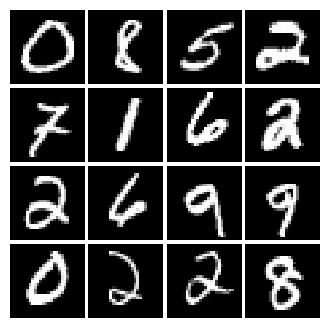

Target


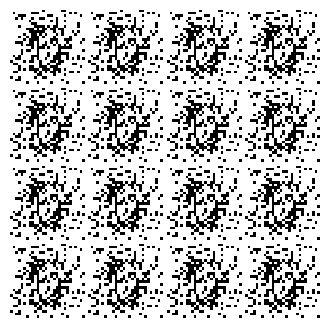

In [ ]:
# Please do not modify anything in this cell

set_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generators
G_A2B = generator().to(device)
G_B2A = generator().to(device)


# Create optimizers for the Discriminator and the Generators
D_solver = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_solver = optim.Adam(G_A2B.parameters(), lr=1e-3, betas=(0.5, 0.999))
C_solver = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=1e-3, betas=(0.5, 0.999))

# Run it!
run_cycle_gan(D, G_A2B, G_B2A, D_solver, G_solver, C_solver, discriminator_loss, generator_loss, cycle_loss)

Now answer the following questions based on the results.

## Question 5

What is the range of final discriminator error displayed in the cell? (choose the closest answer)

1. 0-0.99
2. 1-1.99
3. 2-2.99
4. 3-3.99

## Question 6

What is the range of final generator error displayed in the cell? (choose the closest answer)

1. 0-0.99
2. 1-1.99
3. 2-2.99
4. 3-3.99

## Question 7

What is the range of final cyclic error displayed in the cell? (choose the closest answer)

1. 0-0.99
2. 1-1.99
3. 2-2.99
4. 3-3.99